In [1]:
import numpy as np 
import pandas as pd 

import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.sandbox.distributions.extras import pdf_mvsk
from scipy.interpolate import interp1d 

np.random.seed(1000)

# total number of simulation 
N = 100000

%matplotlib inline

# Index Data

In [2]:
spx_daily = pd.read_csv('SPX_daily.csv').set_index('Date')['Adj Close'].pct_change()
spx_monthly = pd.read_csv('SPX_daily.csv')[['Date', 'Adj Close']]
spx_monthly['Date'] = pd.to_datetime(spx_monthly['Date'])
spx_monthly = spx_monthly.set_index('Date')['Adj Close']
spx_monthly = spx_monthly.resample('m').last().pct_change().dropna()

In [3]:
spx_monthly.mean()*12

0.07572491643990997

In [4]:
spx_monthly.std()*np.sqrt(12)

0.18610959709764208

In [5]:
stats.skew(spx_monthly.dropna())

0.11349673622264717

In [6]:
stats.kurtosis(spx_monthly.dropna())

7.784222062945982

# simulation function

In [7]:
def simulate_normal(mu, sigma, size=(120, N)):
    """
    Simulate return with Gaussian distribution
    """
    return stats.norm.rvs(loc=mu, scale=sigma, size=size)


def simulate_sinh_arcsinh(mu, sigma, skew, tailweight, size=(120, N)):
    """
    Simulate return with Gaussian and sinh arcsinh adjustment for skew and kurtosis
    https://stats.stackexchange.com/questions/462941/transforming-a-multivariate-normal-sample-using-the-sinh-arcsinh-transform
    https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/SinhArcsinh
    """
    z = stats.norm.rvs(loc=0, scale=1, size=size)
    f0 = np.sinh(np.arcsinh(z) * tailweight)
    f0_2 = np.sinh(np.arcsinh(2) * tailweight)    
    f = np.sinh((np.arcsinh(z) + skew) * tailweight) * (2 / f0_2)
    
    return mu/12 + sigma/np.sqrt(12) * f

def simulate_normal_ar(mu, sigma, corr, size=(120, N)):
    """
    Simulate return with Gaussian and auto correlation
    """

    sim_size = (size[0]+1, size[1])
    
    z = stats.norm.rvs(loc=0, scale=1, size=sim_size)
    y = np.zeros(sim_size)
    
    for row in range(1, sim_size[0]):
        y[row] = (1 - corr) * mu + corr * y[row - 1] + np.sqrt(1 - corr**2) * sigma *z[row]
      
    return y[1:]

def simulate_normal_volatility_cluster(mu, sigma, alpha,size=(120, N)):
    """
    Simulate return with Gaussian and volatility clustering
    https://quant.stackexchange.com/questions/22685/simulating-returns-from-arma1-0-garch1-1-model
    """
    sim_size = (size[0]+1, N)
    e = stats.norm.rvs(loc=0, scale=1, size=sim_size)
    r = np.zeros(sim_size)
    si = np.zeros(sim_size)
    w = sigma**2 * (1 - alpha)
    
    for row in range(1, sim_size[0]):
        si[row] = np.sqrt(w + alpha * (r[row-1]**2))
        r[row] = si[row] * e[row]
        
    r = r + mu
    
    return r[1:]
    

def mdd(val):
    """
    Calculate max drawdown for simulation (in negative)
    """
    df = pd.DataFrame(val)
    lvl = df.add(1).cumprod()
    
    max_v = lvl.expanding().max()
    dd =   lvl / max_v - 1
    
    return dd.min()

def mdd_distribution(mdd, vol=0.1):
    n = len(mdd)
    val = [1,2,3,4]
    val = [i * vol for i in val]
    val = [
        len(mdd[mdd <= -i]) / n for i in val
    ]
    return pd.Series(val, ['P(MDD <= -1 * Sigma)', 'P(MDD <= -2 * Sigma)','P(MDD <= -3 * Sigma)','P(MDD <= -4 * Sigma)'])

def simulate_moment(mu, sigma, skew, kurtosis, size=(120, N)):
    func = pdf_mvsk([mu, sigma, skew, kurtosis])
    class your_distribution(stats.rv_continuous):
        def _pdf(self, x):
            return func(x)
    dist = your_distribution()
    res =  dist.rvs(size=size)
    print(size)
    return res


def generate_normal_four_moments(mu, sigma, skew, kurt, size=(120, N), sd_wide = 10):
    f = pdf_mvsk([mu, sigma**2, skew, kurt])
    x = np.linspace(mu - sd_wide * sigma, mu + sd_wide * sigma, num=1000)
    y = [f(i) for i in x]
    yy = np.cumsum(y) / np.sum(y)
    inv_cdf = interp1d(yy, x, fill_value="extrapolate")
    total_size = size[0] * size[1]
    rr = np.random.rand(total_size)
    res = inv_cdf(rr)
    res = np.array(res).reshape(size)
    return res

# Chanching Volatility

In [ ]:
%%time
volatility_sim = dict()
shrape_ratio = 0.5
for vol in range(3, 16):
    volatility_sim.update({
        vol: simulate_normal(vol/100*shrape_ratio/12,vol/100/np.sqrt(12),size=(120, N))
    })

volatility_mdd_dist = dict()
for vol in volatility_sim:
    volatility_mdd_dist.update({
        vol: mdd(volatility_sim[vol])
    })

volatility_res = dict()
for vol in volatility_mdd_dist:
    volatility_res.update({
        vol: mdd_distribution(volatility_mdd_dist[vol], vol/100)
    })
volatility_res = pd.DataFrame(volatility_res).T

# Sharpe ratio

In [ ]:
%%time
sharpe_sim = dict()
for sharpe in (0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7, 0.8, 0.9, 1.):
    sharpe_sim.update({
        sharpe: simulate_normal(0.1*sharpe/12,
                                0.1/np.sqrt(12),size=(120, N))
    })

sharpe_mdd_dist = dict()
for shapre in sharpe_sim:
    sharpe_mdd_dist.update({
        shapre: mdd(sharpe_sim[shapre])
    })

sharpe_res = dict()
for shapre in sharpe_mdd_dist:
    sharpe_res.update({
        shapre: mdd_distribution(sharpe_mdd_dist[shapre], 0.1)
    })
sharpe_res = pd.DataFrame(sharpe_res).T

# Time 

In [ ]:
%%time
sim_time = simulate_normal(0.05/12,
                                0.1/np.sqrt(12),size=(12*40, N))

time_sim = dict()
for year in range(1,31):
    time_sim.update({
        year: sim_time[:(year * 12), :]
    })

time_mdd_dist = dict()
for year in time_sim:
    time_mdd_dist.update({
        year: mdd(time_sim[year])
    })

time_res = dict()
for year in time_mdd_dist:
    time_res.update({
        year: mdd_distribution(time_mdd_dist[year], 0.1)
    })
time_res = pd.DataFrame(time_res).T

In [ ]:
def mdd_distribution(mdd, vol=0.1):
    n = len(mdd)
    val = [1,2,3,4,5]
    val = [i * vol for i in val]
    val = [
        len(mdd[mdd <= -i]) / n for i in val
    ]
    return pd.Series(val, ['P(MDD <= -1 * Sigma)', 'P(MDD <= -2 * Sigma)','P(MDD <= -3 * Sigma)','P(MDD <= -4 * Sigma)', 'P(MDD <= -5 * Sigma)'])

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

fig, ax = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle("Probability of |MDD| > 1,2,3,4 Sigma under Gaussian")

ax[0].set_xlabel("Volatility")
volatility_res.plot(ax=ax[0], legend=True)

ax[1].set_xlabel("Sharpe Ratio")
sharpe_res.plot(ax=ax[1], legend=False)

ax[2].set_xlabel("Years of Horizon")
time_res.plot(ax=ax[2], legend=False)

# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.legend(lines, labels, loc = (0.35, -0.01))

# kurt skew

In [117]:
%%time
skew_sim = dict()
for skew in (-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3):
    skew_sim.update({
        skew: generate_normal_four_moments(0.05/12,
                                0.1/np.sqrt(12), skew, 0,size=(120, N))
    })

skew_mdd_dist = dict()
for skew in skew_sim:
    skew_mdd_dist.update({
        skew: mdd(skew_sim[skew])
    })

skew_res = dict()
for skew in skew_mdd_dist:
    skew_res.update({
        skew: mdd_distribution(skew_mdd_dist[skew], 0.1)
    })
skew_res = pd.DataFrame(skew_res).T

CPU times: total: 18.5 s
Wall time: 38.5 s


In [118]:
%%time
kurt_sim = dict()
for kurt in (0, 1,2,3,4,5,6):
    kurt_sim.update({
        kurt: generate_normal_four_moments(0.05/12,
                                0.1/np.sqrt(12), kurt, 0,size=(120, N))
    })

kurt_mdd_dist = dict()
for kurt in kurt_sim:
    kurt_mdd_dist.update({
        kurt: mdd(kurt_sim[kurt])
    })

kurt_res = dict()
for kurt in kurt_mdd_dist:
    kurt_res.update({
        kurt: mdd_distribution(kurt_mdd_dist[kurt], 0.1)
    })
kurt_res = pd.DataFrame(kurt_res).T

CPU times: total: 18.6 s
Wall time: 37.7 s


In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle("Probability of |MDD| > 1,2,3,4 Sigma with Varying Skew/Kurtosis")

ax[0].set_xlabel("Skew")
skew_res.plot(ax=ax[0], legend=True)

ax[1].set_xlabel("Kurtosis")
kurt_res.plot(ax=ax[1], legend=False)

In [ ]:
%%time
skew_sim = dict()
for skew in (-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3):
    skew_sim.update({
        skew: generate_normal_four_moments(0.05/12,
                                0.1/np.sqrt(12), skew, 0,size=(60, N))
    })

skew_mdd_dist = dict()
for skew in skew_sim:
    skew_mdd_dist.update({
        skew: mdd(skew_sim[skew])
    })

skew_res = dict()
for skew in skew_mdd_dist:
    skew_res.update({
        skew: mdd_distribution(skew_mdd_dist[skew], 0.1)
    })
skew_res = pd.DataFrame(skew_res).T

In [ ]:
%%time
kurt_sim = dict()
for kurt in (0, 1,2,3,4,5,6):
    kurt_sim.update({
        kurt: generate_normal_four_moments(0.05/12,
                                0.1/np.sqrt(12), kurt, 0,size=(60, N))
    })

kurt_mdd_dist = dict()
for kurt in kurt_sim:
    kurt_mdd_dist.update({
        kurt: mdd(kurt_sim[kurt])
    })

kurt_res = dict()
for kurt in kurt_mdd_dist:
    kurt_res.update({
        kurt: mdd_distribution(kurt_mdd_dist[kurt], 0.1)
    })
kurt_res = pd.DataFrame(kurt_res).T

<AxesSubplot:xlabel='Kurtosis'>

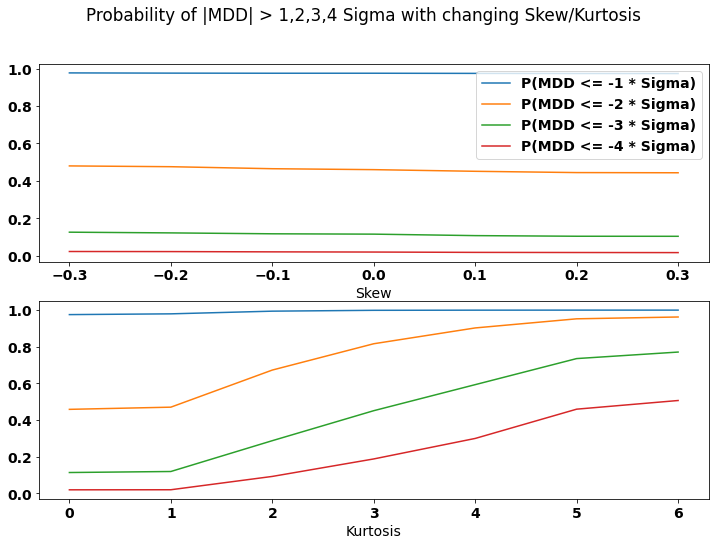

In [120]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle("Probability of |MDD| > 1,2,3,4 Sigma with changing Skew/Kurtosis")

ax[0].set_xlabel("Skew")
skew_res.plot(ax=ax[0], legend=True)

ax[1].set_xlabel("Kurtosis")
kurt_res.plot(ax=ax[1], legend=False)

# auto correlation

In [111]:
%%time
corr_sim = dict()
for corr in (-0.5,-0.4,-0.3,-0.2,-0.1,0, 0.1, 0.2, 0.3,0.4,0.5):
    corr_sim.update({
        corr:simulate_normal_ar(0.05/12, 0.1/np.sqrt(12),corr)
    })

corr_mdd_dist = dict()
for corr in corr_sim:
    corr_mdd_dist.update({
        corr: mdd(corr_sim[corr])
    })

corr_res = dict()
for corr in corr_mdd_dist:
    corr_res.update({
        corr: mdd_distribution(corr_mdd_dist[corr], 0.1)
    })
corr_res = pd.DataFrame(corr_res).T

CPU times: total: 28.5 s
Wall time: 50 s


In [112]:
%%time
cl_sim = dict()
for cl in (0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8):
    cl_sim.update({
        cl:simulate_normal_ar(0.05/12, 0.1/np.sqrt(12),cl)
    })

cl_mdd_dist = dict()
for cl in cl_sim:
    cl_mdd_dist.update({
        cl: mdd(cl_sim[cl])
    })

cl_res = dict()
for cl in cl_mdd_dist:
    cl_res.update({
        cl: mdd_distribution(cl_mdd_dist[cl], 0.1)
    })
cl_res = pd.DataFrame(cl_res).T

CPU times: total: 19.5 s
Wall time: 40.2 s


<AxesSubplot:xlabel='Alpha in Arch'>

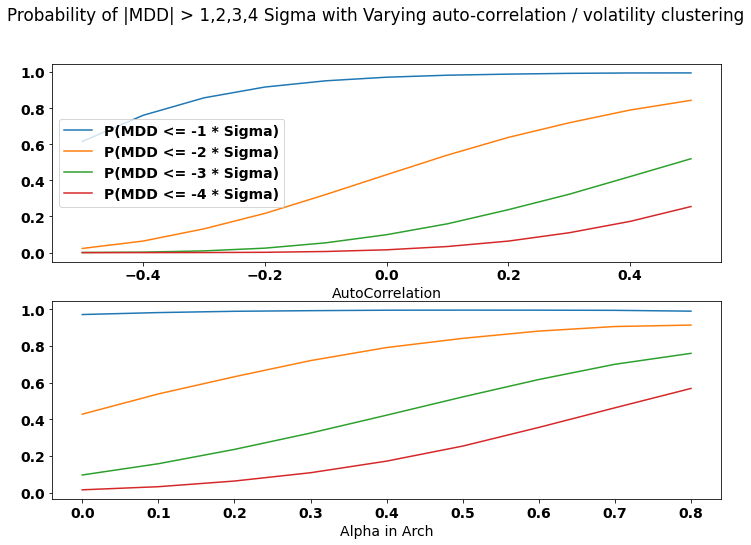

In [121]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle("Probability of |MDD| > 1,2,3,4 Sigma with Varying auto-correlation / volatility clustering")

ax[0].set_xlabel("AutoCorrelation")
corr_res.plot(ax=ax[0], legend=True)

ax[1].set_xlabel("Alpha in Arch")
cl_res.plot(ax=ax[1], legend=False)

# Other not used

In [105]:
test = simulate_normal_volatility_cluster(0.05/12, 0.1/np.sqrt(12), 0., (10000,1)).reshape(-1)

In [106]:
test.mean()

0.004014626846530548

In [107]:
test.std() * np.sqrt(12)

0.1009418923974534

In [108]:
t = pd.Series(test)

In [109]:
(t**2).autocorr()

-0.009870957802175201

In [97]:
from arch import arch_model

In [98]:
am = arch_model(pt * 100, vol='garch', p=0,o=1, q=1, dist='Normal')


In [99]:
res = am.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 136660.75758528727
Iteration:      2,   Func. Count:     15,   Neg. LLF: 136203.4689794018
Iteration:      3,   Func. Count:     23,   Neg. LLF: 8631673969.344753
Iteration:      4,   Func. Count:     29,   Neg. LLF: 50276.582443339554
Iteration:      5,   Func. Count:     35,   Neg. LLF: 237074.6380327281
Iteration:      6,   Func. Count:     42,   Neg. LLF: 49550.45415358167
Iteration:      7,   Func. Count:     48,   Neg. LLF: 49345.49303648148
Iteration:      8,   Func. Count:     53,   Neg. LLF: 49345.44513768963
Iteration:      9,   Func. Count:     58,   Neg. LLF: 49345.44075305872
Iteration:     10,   Func. Count:     63,   Neg. LLF: 49345.440481438956
Iteration:     11,   Func. Count:     68,   Neg. LLF: 49345.44047825124
Iteration:     12,   Func. Count:     72,   Neg. LLF: 49345.440478253186
Optimization terminated successfully    (Exit mode 0)
            Current function value: 49345.44047825124
            Iterations: 

In [100]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -49345.4
Distribution:                  Normal   AIC:                           98698.9
Method:            Maximum Likelihood   BIC:                           98730.5
                                        No. Observations:                20000
Date:                Sun, Sep 24 2023   Df Residuals:                    19999
Time:                        13:24:53   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.4071  1.990e-02     20.454  5.536e-93 [  0.368,  0.446]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.6927      0.109     15.552  1.539e-54 [  1.479,  1.906]
gamma[1]       0.1594  1.260e-02     12.651  1.101e-36 [  0.135,  0.184]
beta[1]        0.7227  1.542e-02     46.869      0.000 [  0.692,  0.753]
========================================================================

Covariance estimator: robust
"""

In [110]:
def simulate_normal_volatility_cluster(mu, sigma, alpha, size=(120, N)):
    """
    Simulate return with Gaussian and volatility clustering
    https://quant.stackexchange.com/questions/22685/simulating-returns-from-arma1-0-garch1-1-model
    """
    sim_size = (size[0]+1, size[1] + 1)
    e = stats.norm.rvs(loc=0, scale=1, size=sim_size)
    r = np.zeros(sim_size)
    si = e.copy()
    w = (sigma**2) * (1 - alpha)
    
    for row in range(1, sim_size[0]):
        si[row] = np.sqrt(w + alpha * (r[row-1]**2))
        r[row] = si[row] * e[row]
        
    r = r + mu
    
    return r[1:]

# Mixed Gaussian

In [347]:
def cal_exteme_mu_sigma(alpha0, mu, sigma, mu1, sigma1):
    alpha1 = 1 - alpha0
    mu0 = (mu - alpha1 * mu1) / alpha0
#     sigma0 = np.sqrt((sigma ** 2 - alpha1 * sigma1 ** 2 - alpha0 * alpha1 * (mu0 - mu1) **2) / alpha0)
#     print((sigma ** 2 - alpha1 * sigma1 ** 2 - alpha0 * alpha1 * (mu0 - mu1) **2) / alpha0)
    sigma0 = np.sqrt((sigma ** 2 - alpha1 * sigma1**2 -alpha1 * (mu1-mu)**2 -alpha0 * (mu0 - mu)**2) / alpha0)
    return mu0, sigma0  

def simulate_mg(alpha, mu, sigma, mu1, sigma1, size=(120, N)):
    mu0, sigma0 = cal_exteme_mu_sigma(alpha, mu, sigma, mu1, sigma1)
    print(mu0 * 12, mu1 * 12, sigma0* np.sqrt(12), sigma1 * np.sqrt(12))
    
    dist0 = stats.norm.rvs(loc=mu0, scale=sigma0, size=size)
    dist1 = stats.norm.rvs(loc=mu1, scale=sigma1, size=size)
    
    alpha0 = stats.rv_discrete(name='custm', values=([0, 1], [1-alpha, alpha])).rvs(size=size)
    alpha1 = -1 * (alpha0 - 1)
    
    dist = dist0 * alpha0 + dist1 * alpha1

    return dist

In [365]:
%%time
mg_sim = dict()
# for mg in (0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04):
# mg_sim.update({
#     1: simulate_normal(0.05/12, 0.1/np.sqrt(12),size=(120, N))
# })
for mg in (0.005, 0.01, 0.02, 0.03, 0.04, 0.05):
    mg_sim.update({
#         mg:simulate_normal_ar(0.05/12, 0.1/np.sqrt(12),cl)
        mg: simulate_mg(mg, 0.05/12, 0.1/np.sqrt(12), 0.053 / 12, 0.08/np.sqrt(12))
    })

mg_mdd_dist = dict()
for mg in mg_sim:
    mg_mdd_dist.update({
        mg: mdd(mg_sim[mg])
    })

mg_res = dict()
for mg in mg_mdd_dist:
    mg_res.update({
        mg: mdd_distribution(mg_mdd_dist[mg], 0.1)
    })
mg_res = pd.DataFrame(mg_res).T
mg_res = mg_res.sort_index()

-0.5470000000000009 0.053000000000000005 0.8345957105089866 0.08
-0.2470000000000007 0.053000000000000005 0.5991452244656549 0.08
-0.09700000000000003 0.053000000000000005 0.42960737889379885 0.08
-0.047000000000000174 0.053000000000000005 0.3543891458082016 0.08
-0.02199999999999997 0.053000000000000005 0.30975797003467087 0.08
-0.007000000000000062 0.053000000000000005 0.2794906080711837 0.08
CPU times: total: 18.6 s
Wall time: 32.1 s


In [366]:
mg_sim[0.05].std() * np.sqrt(12)

0.10003261862891821

(array([2.000000e+00, 2.000000e+00, 1.000000e+00, 0.000000e+00,
        1.000000e+00, 0.000000e+00, 1.000000e+00, 1.000000e+00,
        4.000000e+00, 1.000000e+00, 4.000000e+00, 1.000000e+00,
        5.000000e+00, 1.100000e+01, 1.600000e+01, 2.300000e+01,
        2.500000e+01, 3.000000e+01, 2.500000e+01, 3.900000e+01,
        5.600000e+01, 6.600000e+01, 7.900000e+01, 9.800000e+01,
        1.380000e+02, 1.540000e+02, 1.670000e+02, 2.110000e+02,
        2.890000e+02, 3.300000e+02, 3.390000e+02, 4.280000e+02,
        5.410000e+02, 5.690000e+02, 6.420000e+02, 7.290000e+02,
        8.610000e+02, 9.080000e+02, 1.027000e+03, 1.084000e+03,
        1.234000e+03, 1.428000e+03, 1.382000e+03, 1.621000e+03,
        1.519000e+03, 1.683000e+03, 1.786000e+03, 1.840000e+03,
        2.002000e+03, 2.160000e+03, 7.511000e+03, 8.934900e+04,
        6.547570e+05, 2.332394e+06, 3.996903e+06, 3.293594e+06,
        1.308269e+06, 2.496090e+05, 2.401700e+04, 2.683000e+03,
        1.608000e+03, 1.481000e+03, 1.35

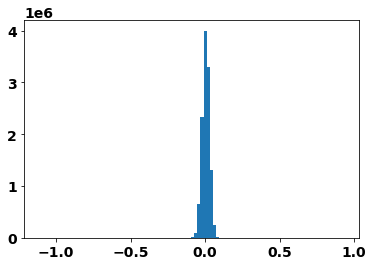

In [367]:
plt.hist(mg_sim[0.005].reshape(-1), bins=100)

In [368]:
mg_res 

,P(MDD <= -1 * Sigma),P(MDD <= -2 * Sigma),P(MDD <= -3 * Sigma),P(MDD <= -4 * Sigma)
0.005,0.85517,0.29503,0.13303,0.06970
0.010,0.87832,0.35723,0.14770,0.05552
0.020,0.90596,0.39997,0.13453,0.03581
0.030,0.92165,0.41785,0.12532,0.02897
0.040,0.93242,0.42474,0.11912,0.02402
0.050,0.93924,0.42202,0.11416,0.02236


<AxesSubplot:xlabel='AutoCorrelation'>

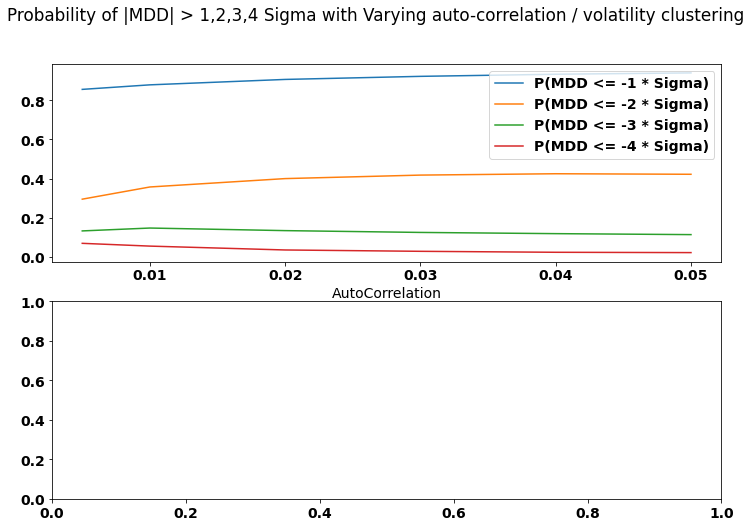

In [369]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle("Probability of |MDD| > 1,2,3,4 Sigma with Varying auto-correlation / volatility clustering")

ax[0].set_xlabel("AutoCorrelation")
mg_res.plot(ax=ax[0], legend=True)

# ax[1].set_xlabel("Alpha in Arch")
# cl_res.plot(ax=ax[1], legend=False)

In [219]:
test = simulate_mg(0.05, 0.05, 0.1, 0.053, 0.097, size=(10000,))

(array([  1.,   0.,   1.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   2.,   1.,   4.,   5.,   4.,   8.,   7.,
         11.,  15.,  19.,  24.,  22.,  28.,  36.,  36.,  51.,  54.,  56.,
         72.,  67.,  84.,  86., 127., 114., 151., 165., 176., 201., 215.,
        241., 235., 246., 246., 270., 267., 305., 273., 292., 336., 353.,
        329., 333., 329., 302., 295., 277., 298., 269., 235., 260., 219.,
        226., 179., 192., 159., 160., 148., 126.,  89.,  98.,  89.,  68.,
         66.,  60.,  47.,  36.,  31.,  31.,  16.,  22.,  25.,  16.,   8.,
         16.,   7.,  12.,   5.,   1.,   1.,   2.,   1.,   1.,   3.,   1.,
          1.]),
 array([-0.1215999 , -0.11931988, -0.11703985, -0.11475983, -0.1124798 ,
        -0.11019978, -0.10791976, -0.10563973, -0.10335971, -0.10107969,
        -0.09879966, -0.09651964, -0.09423961, -0.09195959, -0.08967957,
        -0.08739954, -0.08511952, -0.0828395 , -0.08055947, -0.07827945,
        -0.07599943, -0.07

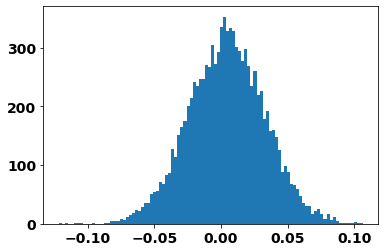

In [220]:
plt.hist(test, bins=100)

In [269]:
def cal_exteme_mu_sigma(alpha0, mu, sigma, mu1, sigma1):
    alpha1 = 1 - alpha0
    mu0 = (mu - alpha1 * mu1) / alpha0
#     sigma0 = np.sqrt((sigma ** 2 - alpha1 * sigma1 ** 2 - alpha0 * alpha1 * (mu0 - mu1) **2) / alpha0)
#     print((sigma ** 2 - alpha1 * sigma1 ** 2 - alpha0 * alpha1 * (mu0 - mu1) **2) / alpha0)
    sigma0 = np.sqrt((sigma ** 2 - alpha1 * sigma1**2 -alpha1 * (mu1-mu)**2 -alpha0 * (mu0 - mu)**2) / alpha0)
    return mu0, sigma0  

def simulate_mg(alpha, mu, sigma, mu1, sigma1, size=(120, N)):
    mu0, sigma0 = cal_exteme_mu_sigma(alpha, mu, sigma, mu1, sigma1)
    print(mu0, sigma0)
    
    dist0 = stats.norm.rvs(loc=mu0, scale=sigma0, size=size)
    dist1 = stats.norm.rvs(loc=mu1, scale=sigma1, size=size)
    
    alpha0 = stats.rv_discrete(name='custm', values=([0, 1], [1-alpha, alpha])).rvs(size=size)
    alpha1 = -1 * (alpha0 - 1)
    
    dist = dist0 * alpha0 + dist1 * alpha1

    return dist

In [276]:
test = simulate_mg(0.3, 0.05 /12, 0.1/np.sqrt(12), 0.055/12, 0.05/np.sqrt(12), size=(10000,1))

0.0031944444444444455 0.04785724979587411


In [277]:
test.mean() * 12, test.std() * np.sqrt(12)

(0.05708412159204286, 0.10079316944679838)

(array([  2.,   3.,   3.,   3.,   2.,   0.,   2.,   4.,   3.,   3.,   4.,
          4.,  10.,   4.,  13.,   7.,  11.,  13.,  16.,  30.,  23.,  33.,
         43.,  34.,  39.,  46.,  52.,  51.,  49.,  59.,  66.,  87.,  95.,
        123., 155., 228., 288., 382., 462., 561., 646., 728., 729., 772.,
        698., 633., 538., 457., 368., 223., 204., 135., 107.,  96.,  69.,
         73.,  53.,  57.,  51.,  36.,  45.,  27.,  33.,  22.,  33.,  24.,
         15.,  10.,  13.,  14.,  18.,   9.,   8.,   6.,   7.,   4.,   7.,
          8.,   2.,   1.,   1.,   2.,   1.,   0.,   1.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-0.14467216, -0.14117833, -0.1376845 , -0.13419066, -0.13069683,
        -0.127203  , -0.12370917, -0.12021534, -0.1167215 , -0.11322767,
        -0.10973384, -0.10624001, -0.10274618, -0.09925234, -0.09575851,
        -0.09226468, -0.08877085, -0.08527702, -0.08178318, -0.07828935,
        -0.07479552, -0.07

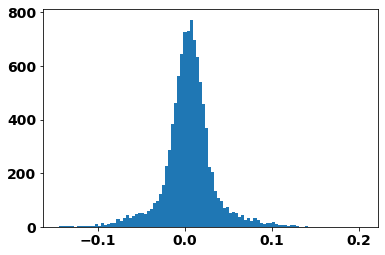

In [278]:
plt.hist(test, bins=100)